# QuakeMigrate example - Icequake detection in Iceland

## Overview

This notebook shows how to run QuakeMigrate for icequake detection, using a 2 minute window of continuous seismic data from Hudson et al. (2019). Please refer to this paper for details and justification of the settings used.

Here, we detail how to:
1. Create travel-time lookup tables for the example seismometer network
2. Run the detect stage to coalesce energy through time
3. Run the trigger stage to determine events above a threshold value
4. Run the locate stage to refine the earthquake location

In [7]:
from pyproj import Proj

import pandas as pd

import QMigrate.io as qio
import QMigrate.lut as qlut
from QMigrate.signal import QuakeScan, Trigger
from QMigrate.signal.onset import CentredSTALTAOnset, ClassicSTALTAOnset
from QMigrate.signal.pick import GaussianPicker

%matplotlib inline

In [2]:
# --- i/o paths ---
station_file = "./inputs/iceland_stations.txt"
data_in = "./inputs/mSEED"
lut_out = "./outputs/lut/icequake.LUT"
out_path = "./outputs/runs"
run_name = "icequake_example"

## Create travel-time lookup tables (LUT)

In [3]:
# --- Read in the station information file ---
stations = qio.stations(station_file)

# --- Define projections ---
cproj = Proj(proj="longlat", ellps="WGS84", datum="WGS84", no_defs=True)
gproj = Proj(proj="lcc", lon_0=-17.224, lat_0=64.328, lat_1=64.32, lat_2=64.335,
             datum="WGS84", ellps="WGS84", units="m", no_defs=True)

# --- Create new LUT ---
# Cell count (x,y,z); cell size (x,y,z in metres)
lut = qlut.LUT(ll_corner=[-17.24363934275664, 64.31947715407385, -1390.],
               ur_corner=[-17.204348515198255, 64.3365202025144, 1390],
               cell_size=[100., 100., 20.], grid_proj=gproj, coord_proj=cproj)

# --- Homogeneous LUT generation ---
vp = 3630
vs = 1833
qlut.compute(lut, stations, method="homogeneous", vp=vp, vs=vs)

# --- Save LUT ---
lut.save(lut_out)

Computing homogeneous travel-time lookup table - 1 of 13
Computing homogeneous travel-time lookup table - 2 of 13
Computing homogeneous travel-time lookup table - 3 of 13
Computing homogeneous travel-time lookup table - 4 of 13
Computing homogeneous travel-time lookup table - 5 of 13
Computing homogeneous travel-time lookup table - 6 of 13
Computing homogeneous travel-time lookup table - 7 of 13
Computing homogeneous travel-time lookup table - 8 of 13
Computing homogeneous travel-time lookup table - 9 of 13
Computing homogeneous travel-time lookup table - 10 of 13
Computing homogeneous travel-time lookup table - 11 of 13
Computing homogeneous travel-time lookup table - 12 of 13
Computing homogeneous travel-time lookup table - 13 of 13


## Coalesce the seismic energy through time

In [4]:
# --- Read in station file ---
stations = qio.stations(station_file)

# --- Create new Archive and set path structure ---
data = qio.Archive(stations=stations, archive_path=data_in)
data.path_structure(archive_format="YEAR/JD/*_STATION_*")

# --- Create new Onset ---
onset = ClassicSTALTAOnset()
onset.p_bp_filter = [10, 125, 4]
onset.s_bp_filter = [10, 125, 4]
onset.p_onset_win = [0.01, 0.25]
onset.s_onset_win = [0.05, 0.5]

# --- Create new QuakeScan ---
scan = QuakeScan(data, lut, onset=onset, output_path=out_path, run_name=run_name)

# --- Set detect parameters ---
scan.sampling_rate = 500
scan.time_step = 0.75
scan.n_cores = 12

# --- Set time period over which to run detect ---
start_time = "2014-06-29T18:41:55.0"
end_time = "2014-06-29T18:42:20.0"

	QuakeMigrate - Coalescence Scanning - Path: outputs/runs - Name: icequake_example



In [5]:
# --- Run detect ---
scan.detect(start_time, end_time)

	DETECT - Continuous Seismic Processing

	Parameters:
		Start time     = 2014-06-29T18:41:55.000000Z
		End   time     = 2014-06-29T18:42:20.000000Z
		Time step (s)  = 0.75
		Number of CPUs = 12

	Onset parameters - using the classic STA/LTA onset
		Data sampling rate = 500

		Bandpass filter P  = [10, 125, 4]
		Bandpass filter S  = [10, 125, 4]

		Onset P [STA, LTA] = [0.01, 0.25]
		Onset S [STA, LTA] = [0.05, 0.5]

~~~~~~~~~~~~~~~~~~~ Processing : 2014-06-29T18:41:53.350000Z - 2014-06-29T18:42:00.750000Z ~~~~~~~~~~~~~~~~~~~
    		Elapsed time: 1.017650 seconds.
~~~~~~~~~~~~~~~~~~~ Processing : 2014-06-29T18:41:54.100000Z - 2014-06-29T18:42:01.500000Z ~~~~~~~~~~~~~~~~~~~
    		Elapsed time: 0.903389 seconds.
~~~~~~~~~~~~~~~~~~~ Processing : 2014-06-29T18:41:54.850000Z - 2014-06-29T18:42:02.250000Z ~~~~~~~~~~~~~~~~~~~
    		Elapsed time: 1.077165 seconds.
~~~~~~~~~~~~~~~~~~~ Processing : 2014-06-29T18:41:55.600000Z - 2014-06-29T18:42:03.000000Z ~~~~~~~~~~~~~~~~~~~
    		Elapsed time: 1.

## Run the trigger stage, to detect and output individual icequakes

nb: We can use the same QuakeScan object here because we are not using a different decimation. If running trigger and locate on grids with different levels of decimation, a new QuakeScan object should be created.

	TRIGGER - Triggering events from coalescence

	Parameters:
		Start time   = 2014-06-29T18:41:55.000000Z
		End   time   = 2014-06-29T18:42:20.000000Z
		Pre/post pad = 120 s

		Marginal window = 2.75 s
		Minimum repeat  = 6.0 s

		Triggering from normalised coalescence stream.

		Detection threshold = 1.8

	Reading in scanmseed...
    ...scanmseed data read from 2014-06-29T18:41:55.000000Z - 2014-06-29T18:42:20.498000Z.

	Warning! No scanmseed data found for pre-pad!
	Warning! No scanmseed data found for post-pad!

	scanmseed read complete.

	Triggering...
	Triggered event 1 of 1

    Plotting triggered events on decimated grid...
    Successfully read .StationAvailability data from 2014-06-29T18:41:55.000000Z - 2014-06-29T18:42:19.750000Z



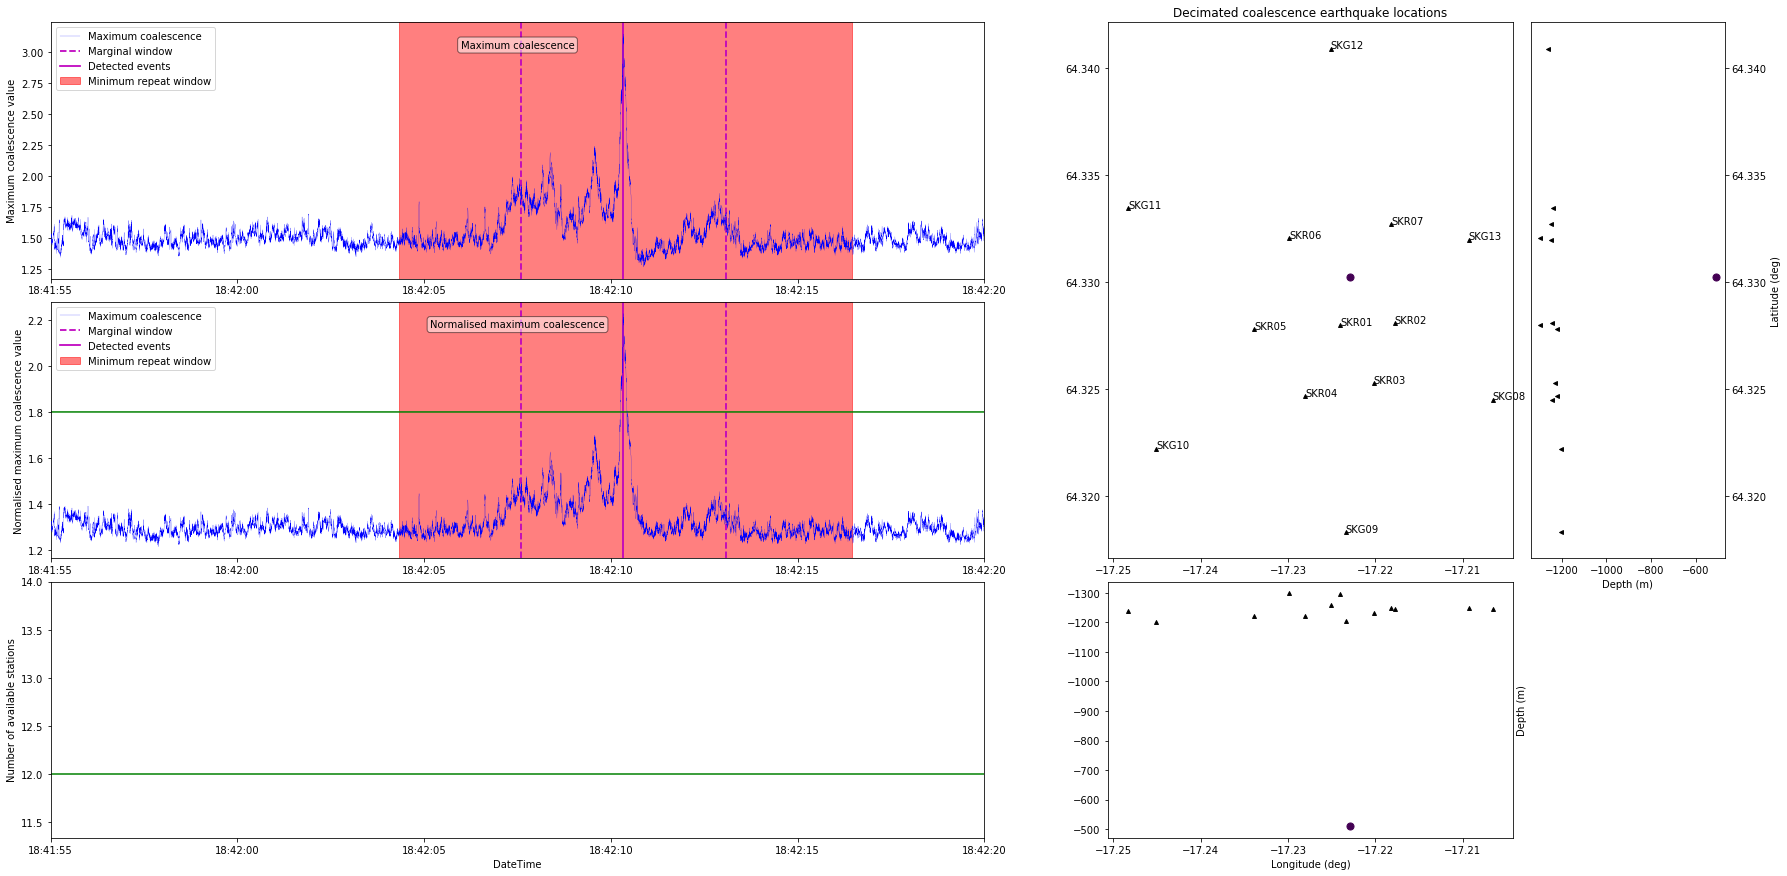

In [8]:
# --- Create new Trigger ---
trig = Trigger(out_path, run_name, stations)

# --- Set trigger parameters ---
trig.marginal_window = 2.75
trig.minimum_repeat = 6.
trig.normalise_coalescence = True

# --- Static threshold ---
trig.detection_threshold = 1.8

# --- Run trigger ---
trig.trigger(start_time, end_time, savefig=True)

## Run the locate stage, to relocate triggered events on a less decimated grid

In [9]:
# --- Create new PhasePicker ---
picker = GaussianPicker(onset=onset)
picker.marginal_window = 2.75
picker.plot_phase_picks = True

# --- Create new QuakeScan ---
scan = QuakeScan(data, lut, onset=onset, picker=picker,
                 output_path=out_path, run_name=run_name, log=True)

# --- Set locate parameters ---
scan.marginal_window = 2.75
scan.n_cores = 12
scan.sampling_rate = 500

# --- Toggle plotting options ---
scan.plot_event_summary = True
scan.plot_event_video = False
scan.plot_station_traces = True

# --- Toggle writing of waveforms ---
scan.write_cut_waveforms = False

	QuakeMigrate - Coalescence Scanning - Path: outputs/runs - Name: icequake_example



In [10]:
# --- Run locate ---
scan.locate(start_time=start_time, end_time=end_time)

	LOCATE - Determining earthquake location and uncertainty

	Parameters:
		Start time     = 2014-06-29T18:41:55.000000Z
		End   time     = 2014-06-29T18:42:20.000000Z
		Number of CPUs = 12

	Onset parameters - using the classic STA/LTA onset
		Data sampling rate = 500

		Bandpass filter P  = [10, 125, 4]
		Bandpass filter S  = [10, 125, 4]

		Onset P [STA, LTA] = [0.01, 0.25]
		Onset S [STA, LTA] = [0.05, 0.5]

	Pick parameters - using the 1-D Gaussian fit to onset
		Pick threshold = 1.0
		Search window  = 0.1s


	EVENT - 1 of 1 - 20140629184210336

	Determining event location...

	Reading waveform data...
    		Elapsed time: 0.109097 seconds.
	Computing 4D coalescence grid...
    		Elapsed time: 13.789359 seconds.
	Making phase picks...
    		Elapsed time: 0.088698 seconds.
	Determining earthquake location and uncertainty...
		Gridded loc: 11   11   56
		Spline  loc: 9.2 12.7 54.2
	Spline warning: spline location outside grid cell with maximum coalescence value
    		Elapsed time: 0.72

## Some of the key outputs

In [12]:
# Show the .event file, containing event origin time and location:
icequake_event_fname = "./outputs/runs/icequake_example/locate/events/20140629184210336.event"
event_df = pd.read_csv(icequake_event_fname)

event_df

,DT,COA,COA_NORM,X,Y,Z,LocalGaussian_X,LocalGaussian_Y,LocalGaussian_Z,LocalGaussian_ErrX,...,GlobalCovariance_Y,GlobalCovariance_Z,GlobalCovariance_ErrX,GlobalCovariance_ErrY,GlobalCovariance_ErrZ,TRIG_COA,DEC_COA,DEC_COA_NORM,ML,ML_Err
0,2014-06-29T18:42:10.336000Z,3.148899,2.226535,-17.22462,64.33087,-306.0,-17.222263,64.329497,-219.237787,1367.252924,...,64.328001,-1.124899,576.60283,576.601073,807.65276,2.22654,3.1489,2.22654,NaN,NaN


In [13]:
# Show the .picks file, containing station time picks:
icequake_pick_fname = "outputs/runs/icequake_example/locate/picks/20140629184210336.picks"
pick_df = pd.read_csv(icequake_pick_fname)

pick_df

,Name,Phase,ModelledTime,PickTime,PickError,SNR
0,SKR01,P,2014-06-29T18:42:10.563542Z,2014-06-29T18:42:10.537219Z,0.008249,17.115957
1,SKR01,S,2014-06-29T18:42:10.786615Z,2014-06-29T18:42:10.760749Z,0.050606,8.248138
2,SKR02,P,2014-06-29T18:42:10.559630Z,2014-06-29T18:42:10.546182Z,0.006367,14.603157
3,SKR02,S,2014-06-29T18:42:10.778868Z,-1,-1.000000,-1.000000
4,SKR03,P,2014-06-29T18:42:10.588888Z,-1,-1.000000,-1.000000
5,SKR03,S,2014-06-29T18:42:10.836809Z,-1,-1.000000,-1.000000
6,SKR04,P,2014-06-29T18:42:10.604714Z,2014-06-29T18:42:10.608140Z,0.006440,9.471328
7,SKR04,S,2014-06-29T18:42:10.868150Z,2014-06-29T18:42:10.906280Z,0.017805,5.114602
8,SKR05,P,2014-06-29T18:42:10.591203Z,2014-06-29T18:42:10.598892Z,0.008520,14.131462
9,SKR05,S,2014-06-29T18:42:10.841394Z,2014-06-29T18:42:10.897246Z,0.040598,8.003716


In [14]:
# Show the coalescence pdf file, containing event origin time and location:
icequake_coal_image_fname = "outputs/runs/icequake_example/locate/summaries/icequake_example_20140629184210336_EventSummary.pdf"
from IPython.display import IFrame # For plotting pdf
IFrame(icequake_coal_image_fname, width=800, height=400) # Plot pdf

References:

Hudson, T.S., Smith, J., Brisbourne, A.M., and White R.S. (2019). Automated detection of basal icequakes and discrimination from surface crevassing. Annals of Glaciology, 79